# 1. Project Context

## Business Problem - Forecast product demand 2 weeks ahead to optimize inventory management and reduce stockouts/overstock situations.

## Technical Challenges
- **Extreme sparsity**: 99% zero demand values in daily data
- **Temporal patterns**: Seasonal and holiday effects
- **Category diversity**: 71 different product categories with unique demand patterns
- **Forecast horizon**: 2-week ahead prediction with 1-week gap

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_log_error
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

# Holiday calendar library
from model_utils import plot_prediction_dashboard
import holidays
from datetime import datetime


# Configure display settings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:
# Load preprocessed daily demand data
# Source: notebook 01 data preprocessing pipeline
data = pd.read_csv('../outputs/daily_data_per_item.csv')
print("Data loaded successfully!")

# Dataset overview
print(f"Dataset size: {data.shape[0]:,} rows × {data.shape[1]} columns")
print(f"Date range: {data['order_date'].min()} to {data['order_date'].max()}")
print(f"Product categories: {data['category'].nunique()}")
print(f"Unique products: {data['product_id'].nunique():,}")

# Display sample data
data.head()

In [ ]:
df = data.copy()
df['order_date'] = pd.to_datetime(df['order_date'])
df['month'] = df['order_date'].dt.month

# Cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("✅ Essential calendar features created")

df.round(4).head()

In [ ]:
# Convert daily data to weekly aggregation
df['order_date'] = pd.to_datetime(df['order_date'])

# Create weekly periods starting Monday
df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)

# Aggregate to weekly level by product and category
weekly_df = df.groupby(['product_id', 'category', 'week']).agg({
    'daily_demand': 'sum',      # Total weekly demand per product
    'price': 'mean',      # Average weekly price per product
    'month': 'first',
    'month_sin': 'first',
    'month_cos': 'first',
}).rename(columns={'daily_demand': 'weekly_demand'}).reset_index()

print(f"Aggregation complete: {len(df):,} daily rows → {len(weekly_df):,} weekly rows")
weekly_df.head()

In [3]:
# Save the data
#weekly_df.to_csv('../outputs/weekly_data_per_item.csv', index=False)
weekly_df = pd.read_csv('../outputs/weekly_data_per_item.csv')
weekly_df['week'] = pd.to_datetime(weekly_df['week'])
weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426768 entries, 0 to 3426767
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   product_id     object        
 1   category       object        
 2   week           datetime64[ns]
 3   weekly_demand  float64       
 4   price          float64       
 5   month          int64         
 6   month_sin      float64       
 7   month_cos      float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 209.2+ MB


In [16]:
weekly_df[weekly_df['weekly_demand'] > 0]

,product_id,category,week,weekly_demand,price,month,month_sin,month_cos,lag_1w,lag_2w,rolling_mean_4w,simple_trend,price_vs_category
89,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2018-05-14,1.0,101.650000,5,5.000000e-01,-8.660254e-01,0.0,0.0,0.00,0.25,0.827961
173,00088930e925c41fd95ebfe695fd2655,auto,2017-12-11,1.0,129.900000,12,-2.449294e-16,1.000000e+00,0.0,0.0,0.00,0.25,0.851306
280,0009406fd7479715e4bef61dd91f2462,bed_bath_table,2017-12-18,1.0,229.000000,12,-2.449294e-16,1.000000e+00,0.0,0.0,0.00,0.25,2.130468
418,000b8f95fcb9e0096488278317764d19,housewares,2018-07-30,1.0,58.900000,7,-5.000000e-01,-8.660254e-01,0.0,0.0,0.00,0.25,0.598058
419,000b8f95fcb9e0096488278317764d19,housewares,2018-08-06,1.0,58.900000,8,-8.660254e-01,-5.000000e-01,1.0,0.0,0.25,0.50,0.598058
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426638,fffdb2d0ec8d6a61f0a0a0db3f25b441,computers_accessories,2018-03-26,1.0,29.990000,3,1.000000e+00,6.123234e-17,0.0,0.0,0.00,0.25,0.191762
3426641,fffdb2d0ec8d6a61f0a0a0db3f25b441,computers_accessories,2018-04-16,1.0,32.847143,4,8.660254e-01,-5.000000e-01,0.0,0.0,0.25,0.00,0.210031
3426643,fffdb2d0ec8d6a61f0a0a0db3f25b441,computers_accessories,2018-04-30,1.0,34.990000,4,8.660254e-01,-5.000000e-01,0.0,1.0,0.25,0.00,0.223733
3426657,fffdb2d0ec8d6a61f0a0a0db3f25b441,computers_accessories,2018-08-06,2.0,34.990000,8,-8.660254e-01,-5.000000e-01,0.0,0.0,0.00,0.50,0.223733


In [13]:
# SIMPLE LAG FEATURES
# Lag features: Historical demand patterns

# Sort by product and time 
weekly_df = weekly_df.sort_values(['product_id', 'week'])

# Core lag features 
weekly_df['lag_1w'] = weekly_df.groupby('product_id')['weekly_demand'].shift(1)
weekly_df['lag_2w'] = weekly_df.groupby('product_id')['weekly_demand'].shift(2)

# Rolling mean, recent volatility
weekly_df['rolling_mean_4w'] = (
    weekly_df.groupby('product_id')['weekly_demand']
    .transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
)
# Simple trend (works better than complex ones)
weekly_df['simple_trend'] = weekly_df.groupby('product_id')['weekly_demand'].transform(
    lambda x: x.rolling(2).mean() - x.rolling(4).mean()
)
# Price relative to category (very powerful for demand prediction)
weekly_df['price_vs_category'] = (
    weekly_df['price'] / 
    weekly_df.groupby('category')['price'].transform('mean')
)
# Fill missing values
weekly_df['lag_1w'] = weekly_df['lag_1w'].fillna(0)
weekly_df['lag_2w'] = weekly_df['lag_2w'].fillna(0)
weekly_df['rolling_mean_4w'] = weekly_df['rolling_mean_4w'].fillna(0)
weekly_df['simple_trend'] = weekly_df['simple_trend'].fillna(0) 
weekly_df['price_vs_category'] = weekly_df['price_vs_category'].fillna(0)

print(f"Missing values: {weekly_df.isna().any().sum()} columns")
print(" Essential features created")
weekly_df.to_csv('../outputs/final_weekly_data.csv', index=False)
weekly_df.round(4).head()


Missing values: 0 columns
 Essential features created


,product_id,category,week,weekly_demand,price,month,month_sin,month_cos,lag_1w,lag_2w,rolling_mean_4w,simple_trend,price_vs_category
0,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-08-29,0.0,101.65,9,-1.0,-0.0,0.0,0.0,0.0,0.0,0.828
1,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-05,0.0,101.65,9,-1.0,-0.0,0.0,0.0,0.0,0.0,0.828
2,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-12,0.0,101.65,9,-1.0,-0.0,0.0,0.0,0.0,0.0,0.828
3,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-19,0.0,101.65,9,-1.0,-0.0,0.0,0.0,0.0,0.0,0.828
4,00066f42aeeb9f3007548bb9d3f33c38,perfumery,2016-09-26,0.0,101.65,9,-1.0,-0.0,0.0,0.0,0.0,0.0,0.828


In [5]:
df = weekly_df.round(4).copy()

encoders = {}
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'].astype(str))
encoders['category'] = le
print(f"✓ Encoded category: {len(le.classes_)} categories")

✓ Encoded category: 71 categories


In [6]:
# Create proper 2-week ahead target variable
print("Creating 2-week ahead target variable...")

df_train = df.copy()
df_train['target_2w'] = df_train.groupby('product_id')['weekly_demand'].shift(-2)

# Remove rows where target is not available (last 2 weeks per product)
df_train = df_train.dropna(subset=['target_2w']).copy()
print(f"Dataset after removing missing targets: {len(df_train):,} rows")

# Remove current demand from features to avoid leakage

features_to_train = [f for f in df_train.columns if f not in ['product_id', 'week', 'weekly_demand', 'target_2w']]

print(f"Features for training: {features_to_train}")
print(f"Target variable: target_2w (demand 2 weeks ahead)")

Creating 2-week ahead target variable...
Dataset after removing missing targets: 3,362,112 rows
Features for training: ['category', 'price', 'month', 'month_sin', 'month_cos', 'lag_1w', 'lag_2w', 'rolling_mean_4w', 'simple_trend', 'price_vs_category']
Target variable: target_2w (demand 2 weeks ahead)


In [7]:
def calculate_rmsle(y_true, y_pred):
    """Calculate Root Mean Squared Logarithmic Error."""
    
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

In [8]:
print("🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET")
print("=" * 60)

print("Using 2-week ahead target variable for training...")
#  Use clean dataset and proper target variable
X = df_train[features_to_train]
y = df_train['target_2w']

print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f" Target range: {y.min():.4f} to {y.max():.4f}")

#  Proper time-based split for time series
print("\n Creating time-based train/test split for time series...")
# Week column is already datetime from Cell 5
split_date = df_train['week'].quantile(0.8)  # 80% for training
train_mask = df_train['week'] <= split_date
test_mask = df_train['week'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print(f"   Training set: {len(X_train):,} samples")
print(f"   Test set: {len(X_test):,} samples")
print(f"   Split date: {split_date}")

print(f"\nTraining LightGBM model for 2-week ahead forecasting...")
model = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Train the model
model.fit(X_train, y_train)
print("✅ Model training complete!")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmsle = calculate_rmsle(y_test, y_pred)

print(f"\n MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   RMSLE: {rmsle:.4f}")
print(f"   R² Score: {r2:.4f}")
print(f"   Model explains {r2*100:.1f}% of demand variation")
print(f"   Average actual demand: {y_test.mean():.4f}")
print(f"   Average predicted demand: {y_pred.mean():.4f}")


🚀 TRAINING MODEL WITH 2-WEEK AHEAD TARGET
Using 2-week ahead target variable for training...
 Features shape: (3362112, 10)
 Target shape: (3362112,)
 Target range: 0.0000 to 59.0000

 Creating time-based train/test split for time series...
   Training set: 2,715,552 samples
   Test set: 646,560 samples
   Split date: 2018-04-02 00:00:00

Training LightGBM model for 2-week ahead forecasting...
✅ Model training complete!

 MODEL PERFORMANCE (2-WEEK AHEAD FORECASTING):
   Mean Absolute Error: 0.0779
   RMSLE: 0.1543
   R² Score: 0.1413
   Model explains 14.1% of demand variation
   Average actual demand: 0.0485
   Average predicted demand: 0.0429


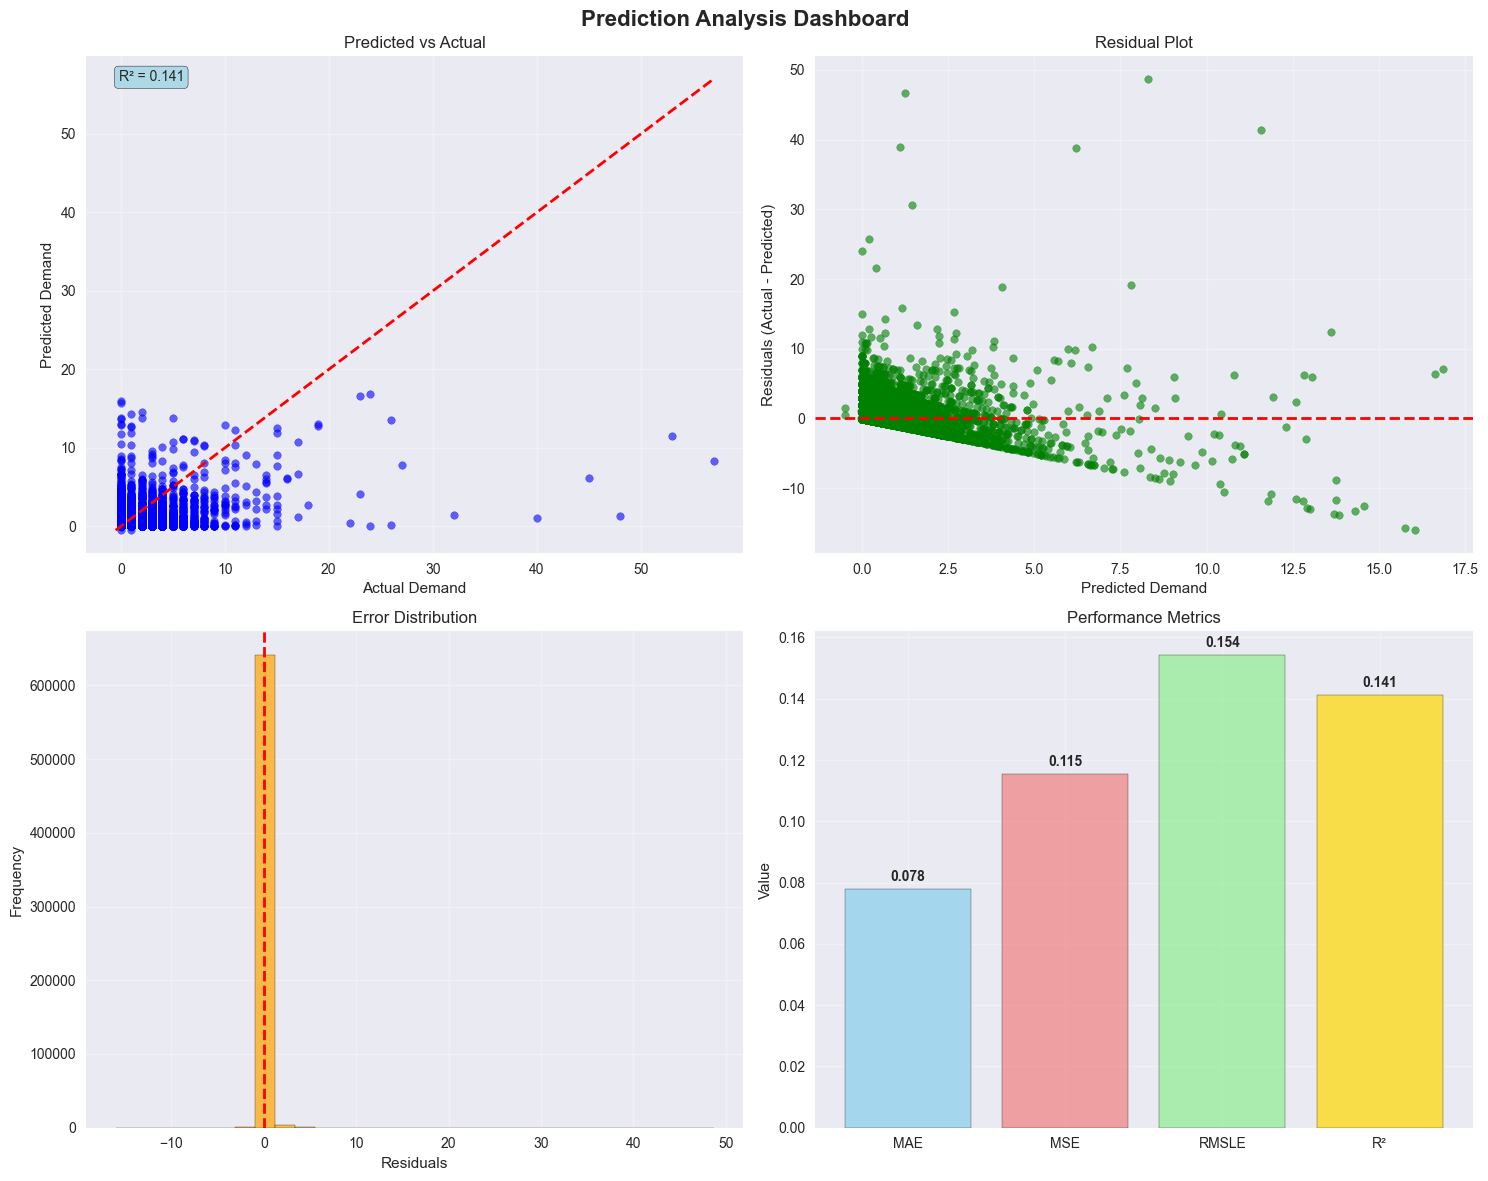

In [9]:
# Plot prediction dashboard
plot_prediction_dashboard(y_test, y_pred)

In [11]:

print("Creating log-transformed 2-week ahead target...")
df_log = df_train.copy()
df_log['target_2w_log'] = np.log1p(df_log.groupby('product_id')['weekly_demand'].shift(-2))
df_log = df_log.dropna(subset=['target_2w_log']).copy()

# Train with log-transformed target
X = df_log[features_to_train]
y = df_log['target_2w_log']

# Time-based split
# Week column is already datetime from Cell 5
split_date = df_log['week'].quantile(0.8)
train_mask = df_log['week'] <= split_date
test_mask = df_log['week'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Train model
model = LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmsle = mean_squared_log_error(y_test, y_pred)

print(f"Log-transformed target - MAE: {mae:.4f}, R²: {r2:.4f}, RMSLE: {rmsle:.4f}")

# Convert back to original scale
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)
print(f"Original scale - MAE: {mean_absolute_error(y_test_original, y_pred_original):.4f}")
print("✅ Model training complete!")

Creating log-transformed 2-week ahead target...
Log-transformed target - MAE: 0.0476, R²: 0.1096, RMSLE: 0.0123
Original scale - MAE: 0.0705
✅ Model training complete!


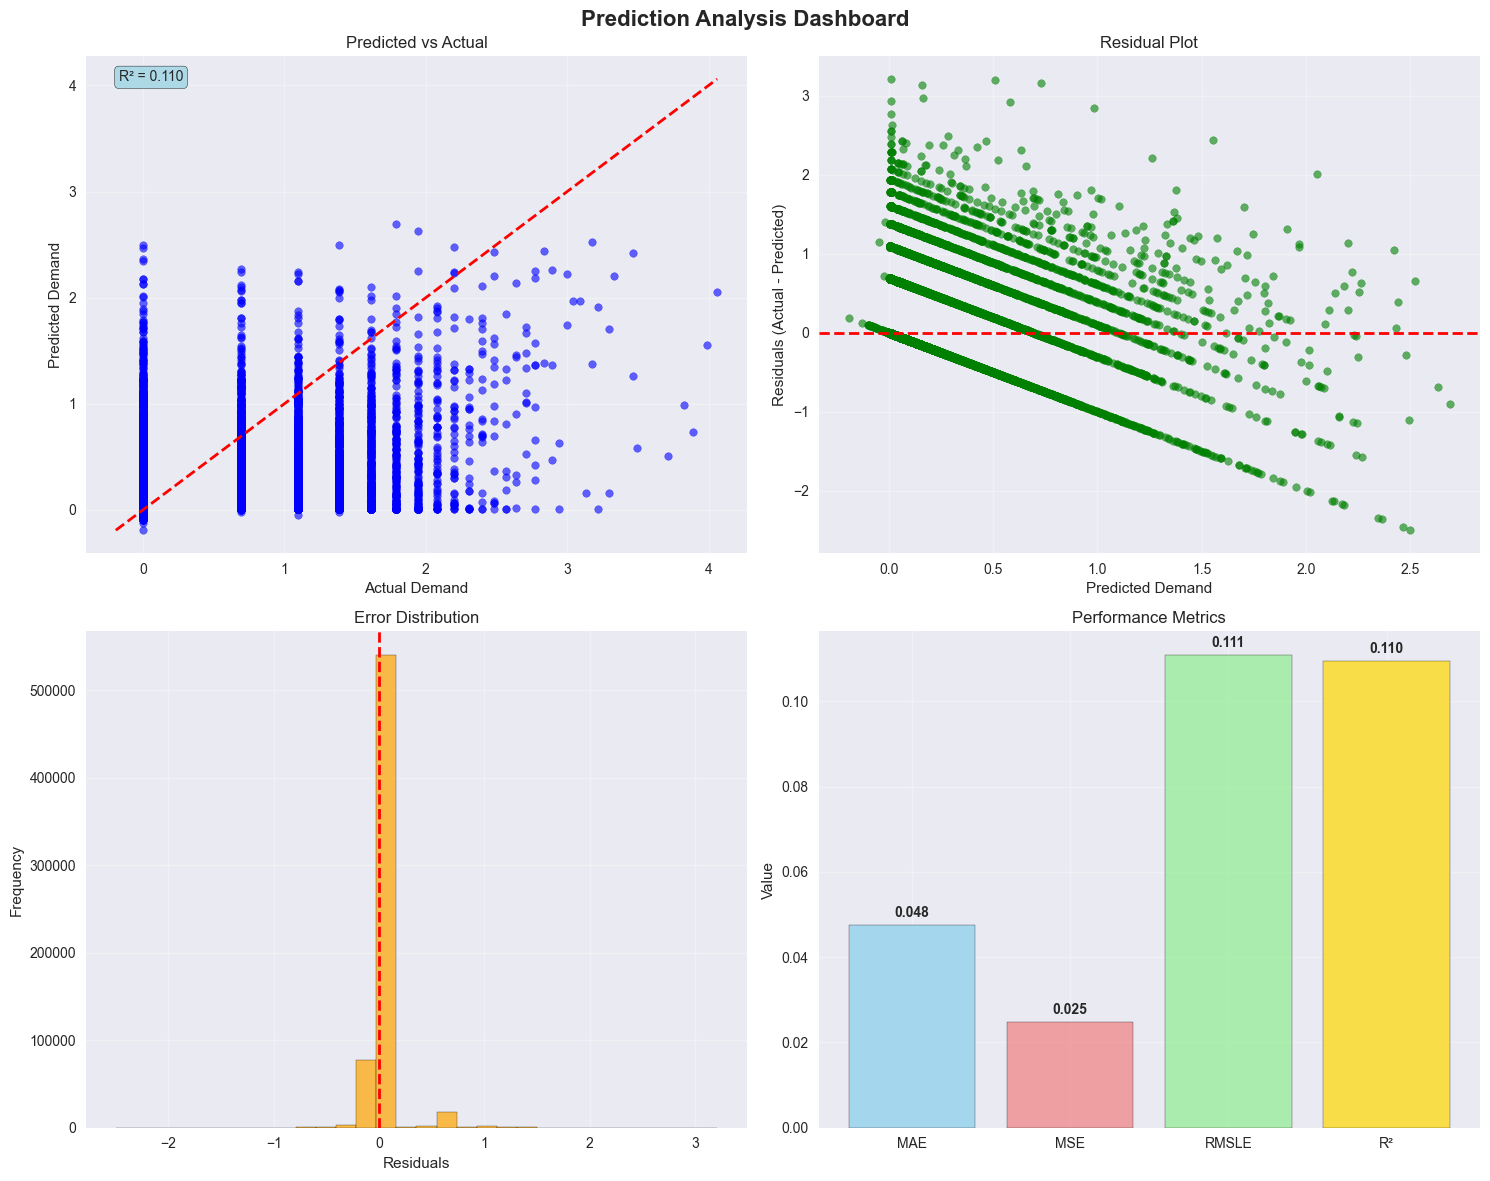

In [12]:
plot_prediction_dashboard(y_test, y_pred)

# Short Reflexion: Weekly Aggregation Results

#### Performance Improvement Analysis ####

- **R² improvement:** 3.6% → 14.1% (3x better)
- **Sparsity reduction:** Daily → Weekly aggregation successfully reduced the some of zero problem
- **Still insufficient:**  14.1% R² means the model explains only 14% of demand variation
- **Log tranformation** didn't helped as expected

#### Why Performance Remains Poor ####
- **Inherent Demand Volatility:** E-commerce demand is naturally intermittent and hard to predict
- **Product-level Granularity:** Individual products have erratic patterns; category-level might work better

#### Recommendations ####
- **Try Category-Level Forecasting**
